**Adaptive MLaaS Composability Model**
---

In [ ]:
import os
import json
import numpy as np
import pandas as pd
import ast
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Paths
csv_file_path = '/content/Combined_MLaaS_Clients.csv'
client_dirs = [
    '/content/drive/MyDrive/MLaaS Genarator Weights/',
    '/content/drive/MyDrive/MLaaS Genarator Weights/NIID/',
    '/content/drive/MyDrive/MLaaS Genarator Weights/NIID_2/'
]
global_model_paths = [
     '/content/drive/MyDrive/MLaaS Genarator Weights/CSV AND GLOBAL/global_round_3.json',
    '/content/drive/MyDrive/MLaaS Genarator Weights/NIID/Global_model/global_round_3.json',
    '/content/drive/MyDrive/MLaaS Genarator Weights/NIID_2/Global_model/global_round_3.json'
]

# Load the CSV file
df = pd.read_csv(csv_file_path)

# Step 1: Parse the 'Data_Distribution' from string to dictionary
df['Parsed_Distribution'] = df['Data_Distribution'].apply(ast.literal_eval)

# Step 2: Compute the global reference distribution
client_distributions = np.array([list(dist.values()) for dist in df['Parsed_Distribution']])
global_reference_distribution = np.mean(client_distributions, axis=0)

# Step 3: Define thresholds
THRESHOLD_DUM = 490
THRESHOLD_SUM = 1.5
THRESHOLD_HQS = 0.05
THRESHOLD_SRS = 0.7
ALPHA_SUM = 1

# Step 4: Define functions for existing measurements
def compute_dum(client_distribution):
    ed = np.sqrt(np.sum((np.array(list(client_distribution.values())) - global_reference_distribution) ** 2))
    return 1 if ed < THRESHOLD_DUM else 0

def compute_sum(response_time, avg_response_time):
    value = (response_time / avg_response_time) ** ALPHA_SUM
    return 1 if value < THRESHOLD_SUM else 0

def compute_hqs(quality_factor, avg_quality_factor):
    similarity = np.abs(quality_factor - avg_quality_factor)
    return 1 if similarity <= THRESHOLD_HQS else 0

def compute_srs(reliability_score):
    return 1 if reliability_score >= THRESHOLD_SRS else 0

# Flatten model weights for MUM calculation
def flatten_weights(weights_dict):
    flat_weights = []
    for key in weights_dict:
        layer_weights = np.array(weights_dict[key])
        flat_weights.extend(layer_weights.flatten())
    return np.array(flat_weights)

def calculate_mum(local_weights, global_weights):
    min_length = min(len(local_weights), len(global_weights))
    local_weights = local_weights[:min_length]
    global_weights = global_weights[:min_length]
    differences = np.abs((local_weights - global_weights) / global_weights)
    return np.mean(differences)

# Load global models
global_models = []
for path in global_model_paths:
    with open(path, 'r') as f:
        global_weights = json.load(f)
        global_models.append(flatten_weights(global_weights))

# Step 5: Calculate average response time and quality factor
avg_response_time = df['Computation_Time'].mean()
avg_quality_factor = df['Quality_Factor'].mean()

# Initialize a list for results
binary_vector = []

# Process each client in the directories
client_index = 0
for dir_index, client_dir in enumerate(client_dirs):
    for filename in sorted(os.listdir(client_dir)):
        if filename.endswith('.json'):
            client_file_path = os.path.join(client_dir, filename)
            with open(client_file_path, 'r') as client_file:
                local_weights = json.load(client_file)
                local_flat = flatten_weights(local_weights)
                mum_value = calculate_mum(local_flat, global_models[dir_index])

                # Get corresponding row from DataFrame
                row = df.iloc[client_index]
                dum_score = compute_dum(row['Parsed_Distribution'])
                sum_score = compute_sum(row['Computation_Time'], avg_response_time)
                hqs_score = compute_hqs(row['Quality_Factor'], avg_quality_factor)
                srs_score = compute_srs(row['Reliability_Score'])
                mum_score = 1 if mum_value < 0.3 else 0  # Threshold for MUM

                # Append scores
                client_vector = [dum_score, sum_score, hqs_score, srs_score, mum_score]
                binary_vector.append(client_vector)
                client_index += 1

# Convert to DataFrame and save
binary_vector_df = pd.DataFrame(binary_vector, columns=['DUM', 'SUM', 'HQS', 'SRS', 'MUM'])
binary_vector_df['Client'] = df['Client'].values
output_file = '/content/drive/MyDrive/MLaaS Genarator Weights/Final_Results_With_MUM.csv'
binary_vector_df.to_csv(output_file, index=False)

# Display the results
print("Final scores with MUM included:")
print(binary_vector_df)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Final scores with MUM included:
     DUM  SUM  HQS  SRS  MUM     Client
0      1    1    1    1    1   client_1
1      1    1    1    1    1   client_2
2      1    1    1    1    1   client_3
3      1    1    1    1    1   client_4
4      1    1    1    1    1   client_5
..   ...  ...  ...  ...  ...        ...
175    1    1    0    0    1  client_16
176    1    1    1    0    1  client_17
177    1    1    1    0    1  client_18
178    1    1    1    0    1  client_19
179    1    1    1    0    1  client_20

[180 rows x 6 columns]


In [ ]:
binary_vector_df['MUM'].value_counts()

,count
MUM,
1,110
0,70


In [ ]:
import pandas as pd
import numpy as np
import ast

# Load the CSV file
file_path = '/content/Combined_MLaaS_Clients.csv'
df = pd.read_csv(file_path)

# Step 1: Parse the 'Data_Distribution' from string to dictionary
df['Parsed_Distribution'] = df['Data_Distribution'].apply(ast.literal_eval)

# Step 2: Compute the global reference distribution
client_distributions = np.array([list(dist.values()) for dist in df['Parsed_Distribution']])
global_reference_distribution = np.mean(client_distributions, axis=0)

# Step 3: Define thresholds
THRESHOLD_DUM = 405  # Adjust as needed
THRESHOLD_SUM = 1.5  # Example threshold for response time ratio
THRESHOLD_HQS = 0.05  # Allowable difference in quality factor
THRESHOLD_SRS = 0.7  # Minimum acceptable reliability score
ALPHA_SUM = 1  # Power parameter for SUM computation

# Step 4: Define functions for each measurement
def compute_dum(client_distribution):
    ed = np.sqrt(np.sum((np.array(list(client_distribution.values())) - global_reference_distribution) ** 2))
    return 1 if ed < THRESHOLD_DUM else 0

def compute_sum(response_time, avg_response_time):
    value = (response_time / avg_response_time) ** ALPHA_SUM
    return 1 if value < THRESHOLD_SUM else 0

def compute_hqs(quality_factor, avg_quality_factor):
    similarity = np.abs(quality_factor - avg_quality_factor)
    return 1 if similarity <= THRESHOLD_HQS else 0

def compute_srs(reliability_score):
    return 1 if reliability_score >= THRESHOLD_SRS else 0

# Step 5: Calculate average response time and quality factor for comparison
avg_response_time = df['Computation_Time'].mean()
avg_quality_factor = df['Quality_Factor'].mean()

# Step 6: Apply functions and generate the binary vector
binary_vector = []

for index, row in df.iterrows():
    dum_score = compute_dum(row['Parsed_Distribution'])
    sum_score = compute_sum(row['Computation_Time'], avg_response_time)
    hqs_score = compute_hqs(row['Quality_Factor'], avg_quality_factor)
    srs_score = compute_srs(row['Reliability_Score'])

    # Combine all scores into a vector
    client_vector = [dum_score, sum_score, hqs_score, srs_score]
    binary_vector.append(client_vector)

# Convert to DataFrame for better visualization
binary_vector_df = pd.DataFrame(binary_vector, columns=['DUM', 'SUM', 'HQS', 'SRS'])
binary_vector_df['Client'] = df['Client'].values

# Save the results to a new CSV file
output_file = '/content/Adaptive_MLaaS_Composition.csv'
binary_vector_df.to_csv(output_file, index=False)

# Display the result
print("Binary vector scores for each client:")
print(binary_vector_df)


Binary vector scores for each client:
     DUM  SUM  HQS  SRS     Client
0      1    1    1    1   client_1
1      1    1    1    1   client_2
2      1    1    1    1   client_3
3      1    1    1    1   client_4
4      1    1    1    1   client_5
..   ...  ...  ...  ...        ...
175    0    1    0    0  client_16
176    0    1    1    0  client_17
177    0    1    1    0  client_18
178    0    1    1    0  client_19
179    0    1    1    0  client_20

[180 rows x 5 columns]


In [ ]:
binary_vector_df['DUM'].value_counts()

,count
DUM,
0,120
1,60


In [ ]:
binary_vector_df['SUM'].value_counts()

,count
SUM,
1,153
0,27


In [ ]:
binary_vector_df['HQS'].value_counts()

,count
HQS,
0,137
1,43


In [ ]:
binary_vector_df['SRS'].value_counts()

,count
SRS,
1,90
0,90


**Experiment setup**
---

In [3]:
# Re-import necessary libraries after state reset
import pandas as pd
import matplotlib.pyplot as plt
Combined = pd.read_csv('/content/Combined_MLaaS_Service.csv')
Combined

,Unnamed: 0.4,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,Client,Round,Data_Distribution,Computation_Time,Quality_Factor,Reliability_Score,MLaaS_ID,model category,QualityCategory,Service_ID
0,0,0,0,1,1,client_2,1,"{0: 307, 1: 332, 2: 282, 3: 313, 4: 298, 5: 24...",1.536191,0.5383,0.733767,2,Minist16,0,1
1,1,1,1,19,19,client_20,1,"{0: 297, 1: 325, 2: 309, 3: 314, 4: 290, 5: 26...",1.480564,0.6062,0.748367,20,Minist16,0,2
2,2,2,2,25,25,client_6,2,"{0: 287, 1: 361, 2: 278, 3: 335, 4: 279, 5: 26...",1.425591,0.7786,0.715533,26,Minist16,0,3
3,3,3,3,29,29,client_10,2,"{0: 308, 1: 339, 2: 308, 3: 279, 4: 285, 5: 27...",2.424607,0.8028,0.742767,30,Minist16,0,4
4,4,4,4,30,30,client_11,2,"{0: 275, 1: 346, 2: 296, 3: 296, 4: 288, 5: 27...",2.072800,0.7983,0.740467,31,Minist16,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2475,2475,2475,2475,1443,1443,client_4,9,"{0: 50, 1: 50, 2: 50, 3: 50, 4: 50, 5: 50, 6: ...",1.696836,0.7548,0.777390,364,HAR64,0,2476
2476,2476,2476,2476,415,415,client_16,2,"{0: 100, 1: 100, 2: 100, 3: 100, 4: 100, 5: 10...",1.890466,0.7049,0.778200,236,HAR64,0,2477
2477,2477,2477,2477,1837,1837,client_18,18,"{0: 300, 1: 300, 2: 300, 3: 300, 4: 300, 5: 30...",8.042612,0.8362,0.799320,358,HAR64,0,2478
2478,2478,2478,2478,170,170,client_11,3,"{0: 100, 1: 100, 2: 100, 3: 100, 4: 100, 5: 10...",0.724259,0.6458,0.492667,171,HAR64,0,2479


In [4]:
Combined = Combined.drop(columns=['Unnamed: 0.4', 'Unnamed: 0.3', 'Unnamed: 0.2', 'Unnamed: 0.1',
       'Unnamed: 0'])

Combined

,Client,Round,Data_Distribution,Computation_Time,Quality_Factor,Reliability_Score,MLaaS_ID,model category,QualityCategory,Service_ID
0,client_2,1,"{0: 307, 1: 332, 2: 282, 3: 313, 4: 298, 5: 24...",1.536191,0.5383,0.733767,2,Minist16,0,1
1,client_20,1,"{0: 297, 1: 325, 2: 309, 3: 314, 4: 290, 5: 26...",1.480564,0.6062,0.748367,20,Minist16,0,2
2,client_6,2,"{0: 287, 1: 361, 2: 278, 3: 335, 4: 279, 5: 26...",1.425591,0.7786,0.715533,26,Minist16,0,3
3,client_10,2,"{0: 308, 1: 339, 2: 308, 3: 279, 4: 285, 5: 27...",2.424607,0.8028,0.742767,30,Minist16,0,4
4,client_11,2,"{0: 275, 1: 346, 2: 296, 3: 296, 4: 288, 5: 27...",2.072800,0.7983,0.740467,31,Minist16,0,5
...,...,...,...,...,...,...,...,...,...,...
2475,client_4,9,"{0: 50, 1: 50, 2: 50, 3: 50, 4: 50, 5: 50, 6: ...",1.696836,0.7548,0.777390,364,HAR64,0,2476
2476,client_16,2,"{0: 100, 1: 100, 2: 100, 3: 100, 4: 100, 5: 10...",1.890466,0.7049,0.778200,236,HAR64,0,2477
2477,client_18,18,"{0: 300, 1: 300, 2: 300, 3: 300, 4: 300, 5: 30...",8.042612,0.8362,0.799320,358,HAR64,0,2478
2478,client_11,3,"{0: 100, 1: 100, 2: 100, 3: 100, 4: 100, 5: 10...",0.724259,0.6458,0.492667,171,HAR64,0,2479


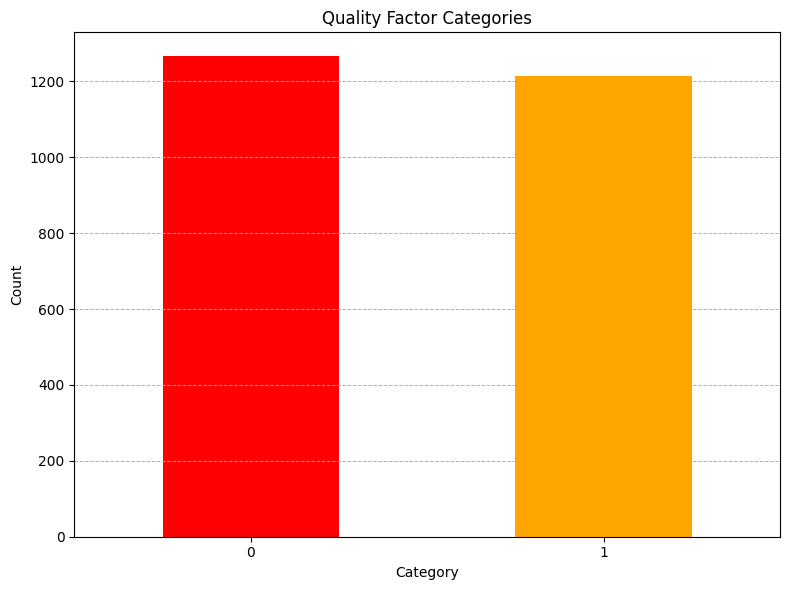

In [5]:
import pandas as pd
import matplotlib.pyplot as plt


# Categorize the QualityFactor values
def categorize_quality(factor):
    if factor < 0.80:
        return 0
    else:
        return 1

# Apply categorization
Combined['QualityCategory'] = Combined['Reliability_Score'].apply(categorize_quality)

# Count the occurrences of each category
category_counts = Combined['QualityCategory'].value_counts()

# Plotting the histogram
plt.figure(figsize=(8, 6))
category_counts.plot(kind='bar', color=['red', 'orange', 'green'])
plt.title('Quality Factor Categories')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', linewidth=0.7)
plt.tight_layout()
plt.show()

**Adaptive MlaaS Composition**
---

In [6]:
AdaptiveMLaaS = pd.read_csv('/content/Adaptive_MLaaS_Composition.csv')
AdaptiveMLaaS

,Unnamed: 0.4,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,DUM,SUM,HQS,SRS,MUM,Client,model category,Composability_Score,Service_ID
0,0,0,0,1,1,1,1,1,1,1,client_2,Minist16,1,1
1,1,1,1,19,19,1,1,1,1,1,client_20,Minist16,1,2
2,2,2,2,25,25,1,1,0,1,1,client_6,Minist16,1,3
3,3,3,3,29,29,1,0,0,1,1,client_10,Minist16,0,4
4,4,4,4,30,30,1,1,0,1,1,client_11,Minist16,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2475,2475,2475,2475,1443,1443,1,1,0,0,0,client_6,HAR64,0,2476
2476,2476,2476,2476,415,415,1,1,0,1,0,client_17,HAR64,0,2477
2477,2477,2477,2477,1837,1837,1,1,1,0,0,client_7,HAR64,0,2478
2478,2478,2478,2478,170,170,1,1,0,0,1,client_11,HAR64,0,2479


In [ ]:
AdaptiveMLaaS['model category'].value_counts()

,count
model category,
Minist64,532
FMinist32,387
FMinist16,307
HAR32,240
HAR16,239
HAR64,238
FMinist64,237
Minist32,172
Minist16,128


In [ ]:
import pandas as pd
import numpy as np
# Assigning weights to each metric
weights = {
    'DUM': 0.7,
    'SUM': 0.7,
    'HQS': 0.6,
    'SRS': 0.9,
    'MUM': 0.9 # Assuming equal weights; you can adjust as needed
}
# Calculating the composability score
AdaptiveMLaaS['Composability_Score'] = (
    AdaptiveMLaaS['DUM'] * weights['DUM'] +
   AdaptiveMLaaS['SUM'] * weights['SUM'] +
    AdaptiveMLaaS['HQS'] * weights['HQS'] +
    AdaptiveMLaaS['SRS'] * weights['SRS'] +
    AdaptiveMLaaS['MUM'] * weights['MUM']
) / 5  # Division by 1 is not needed since weights sum to 1, but kept for clarity

# Ensure the score is between 0 and 1 (it should be already due to the weighting scheme)
AdaptiveMLaaS['Composability_Score'] = AdaptiveMLaaS['Composability_Score'].clip(0, 1)
AdaptiveMLaaS

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,DUM,SUM,HQS,SRS,MUM,Client,model category,Composability_Score,Service_ID
0,0,1,1,1,1,1,1,1,client_2,Minist16,0.76,1
1,1,19,19,1,1,1,1,1,client_20,Minist16,0.76,2
2,2,25,25,1,1,0,1,1,client_6,Minist16,0.64,3
3,3,29,29,1,0,0,1,1,client_10,Minist16,0.50,4
4,4,30,30,1,1,0,1,1,client_11,Minist16,0.64,5
...,...,...,...,...,...,...,...,...,...,...,...,...
2475,2475,1443,1443,1,1,0,0,0,client_6,HAR64,0.28,2476
2476,2476,415,415,1,1,0,1,0,client_17,HAR64,0.46,2477
2477,2477,1837,1837,1,1,1,0,0,client_7,HAR64,0.40,2478
2478,2478,170,170,1,1,0,0,1,client_11,HAR64,0.46,2479


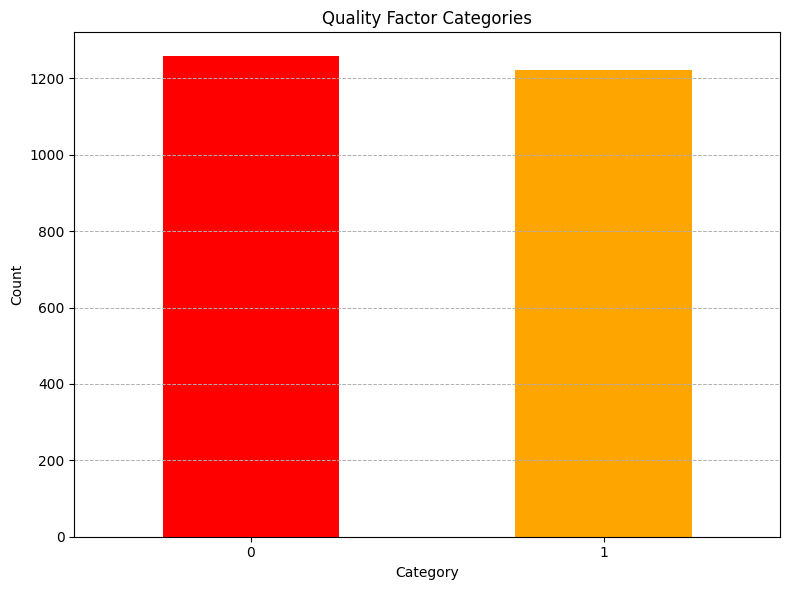

In [ ]:
# Re-import necessary libraries after state reset
import pandas as pd
import matplotlib.pyplot as plt
# Categorize the QualityFactor values
def categorize_quality(factor):
    if factor < 0.55:
        return 0
    else:
        return 1
# Apply categorization
AdaptiveMLaaS['Composability_Score'] = AdaptiveMLaaS['Composability_Score'].apply(categorize_quality)
# Count the occurrences of each category
category_counts = AdaptiveMLaaS['Composability_Score'].value_counts()
# Plotting the histogram
plt.figure(figsize=(8, 6))
category_counts.plot(kind='bar', color=['red', 'orange', 'green'])
plt.title('Quality Factor Categories')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', linewidth=0.7)
plt.tight_layout()
plt.show()

In [ ]:
# Adding 'Service_ID' column to the existing AdaptiveMLS DataFrame
Combined['Service_ID'] = range(1, len(Combined) + 1)
AdaptiveMLaaS['Service_ID'] = range(1, len(AdaptiveMLaaS) + 1)

**Rule-Based Adaptive composition**
---

In [8]:
Combined['MLaaS_CS'] = AdaptiveMLaaS['Composability_Score']

In [9]:
Combined

,Client,Round,Data_Distribution,Computation_Time,Quality_Factor,Reliability_Score,MLaaS_ID,model category,QualityCategory,Service_ID,MLaaS_CS
0,client_2,1,"{0: 307, 1: 332, 2: 282, 3: 313, 4: 298, 5: 24...",1.536191,0.5383,0.733767,2,Minist16,0,1,1
1,client_20,1,"{0: 297, 1: 325, 2: 309, 3: 314, 4: 290, 5: 26...",1.480564,0.6062,0.748367,20,Minist16,0,2,1
2,client_6,2,"{0: 287, 1: 361, 2: 278, 3: 335, 4: 279, 5: 26...",1.425591,0.7786,0.715533,26,Minist16,0,3,1
3,client_10,2,"{0: 308, 1: 339, 2: 308, 3: 279, 4: 285, 5: 27...",2.424607,0.8028,0.742767,30,Minist16,0,4,0
4,client_11,2,"{0: 275, 1: 346, 2: 296, 3: 296, 4: 288, 5: 27...",2.072800,0.7983,0.740467,31,Minist16,0,5,1
...,...,...,...,...,...,...,...,...,...,...,...
2475,client_4,9,"{0: 50, 1: 50, 2: 50, 3: 50, 4: 50, 5: 50, 6: ...",1.696836,0.7548,0.777390,364,HAR64,0,2476,0
2476,client_16,2,"{0: 100, 1: 100, 2: 100, 3: 100, 4: 100, 5: 10...",1.890466,0.7049,0.778200,236,HAR64,0,2477,0
2477,client_18,18,"{0: 300, 1: 300, 2: 300, 3: 300, 4: 300, 5: 30...",8.042612,0.8362,0.799320,358,HAR64,0,2478,0
2478,client_11,3,"{0: 100, 1: 100, 2: 100, 3: 100, 4: 100, 5: 10...",0.724259,0.6458,0.492667,171,HAR64,0,2479,0


In [10]:
Combined.to_csv("/content/Combined_MLaaS_Service.csv")

In [40]:
import pandas as pd
import numpy as np

# Load the CSV file
file_path = "/content/Combined_MLaaS_Service.csv"
QAS_DF = pd.read_csv(file_path)

# Ensure Data_Volume is computed from Data_Distribution if not already present
if "Data_Volume" not in QAS_DF.columns:
    QAS_DF["Data_Volume"] = QAS_DF["Data_Distribution"].apply(lambda x: sum(eval(x).values()))

# Extract relevant columns for analysis
columns_to_analyze = ["Data_Volume", "Computation_Time", "Quality_Factor", "Reliability_Score"]

# Get min, max, and mean values for each column dynamically
feature_stats = {
    col: {
        "min": QAS_DF[col].min(),
        "max": QAS_DF[col].max(),
        "mean": QAS_DF[col].mean(),
        "std": QAS_DF[col].std()
    }
    for col in columns_to_analyze
}

# Define function for rule-based scoring
def rule_based_score(row, feature_stats):
    """
    Computes a composability score (0 to 1) based on dynamically determined thresholds from dataset.
    """
    # Retrieve min-max range dynamically for alignment
    data_volume_min, data_volume_max = feature_stats["Data_Volume"]["min"], feature_stats["Data_Volume"]["max"]
    computation_time_min, computation_time_max = feature_stats["Computation_Time"]["min"], feature_stats["Computation_Time"]["max"]
    quality_factor_min, quality_factor_max = feature_stats["Quality_Factor"]["min"], feature_stats["Quality_Factor"]["max"]
    reliability_min, reliability_max = feature_stats["Reliability_Score"]["min"], feature_stats["Reliability_Score"]["max"]

    # Normalize each feature within its range
    data_volume_score = (row["Data_Volume"] - data_volume_min) / (data_volume_max - data_volume_min)
    computation_time_score = 1 - (row["Computation_Time"] - computation_time_min) / (computation_time_max - computation_time_min)  # Lower is better
    quality_factor_score = (row["Quality_Factor"] - quality_factor_min) / (quality_factor_max - quality_factor_min)
    reliability_score = (row["Reliability_Score"] - reliability_min) / (reliability_max - reliability_min)

    # Compute weighted score
    final_score = (0.25 * data_volume_score +
                   0.25 * computation_time_score +
                   0.25 * quality_factor_score +
                   0.25 * reliability_score)

    return final_score

# Apply scoring function
QAS_DF["Composability_Score"] = QAS_DF.apply(lambda row: rule_based_score(row, feature_stats), axis=1)
QAS_DF["Rule-Based AC"] = QAS_DF["Composability_Score"].apply(lambda x: 1 if x > 0.8 else 0)
# Save the updated DataFrame
QAS_DF

,Unnamed: 0,Client,Round,Data_Distribution,Computation_Time,Quality_Factor,Reliability_Score,MLaaS_ID,model category,QualityCategory,Service_ID,MLaaS_CS,Data_Volume,Composability_Score,Rule-Based AC
0,0,client_2,1,"{0: 307, 1: 332, 2: 282, 3: 313, 4: 298, 5: 24...",1.536191,0.5383,0.733767,2,Minist16,0,1,1,3000,0.716320,0
1,1,client_20,1,"{0: 297, 1: 325, 2: 309, 3: 314, 4: 290, 5: 26...",1.480564,0.6062,0.748367,20,Minist16,0,2,1,3000,0.740346,0
2,2,client_6,2,"{0: 287, 1: 361, 2: 278, 3: 335, 4: 279, 5: 26...",1.425591,0.7786,0.715533,26,Minist16,0,3,1,3000,0.779921,0
3,3,client_10,2,"{0: 308, 1: 339, 2: 308, 3: 279, 4: 285, 5: 27...",2.424607,0.8028,0.742767,30,Minist16,0,4,0,3000,0.789262,0
4,4,client_11,2,"{0: 275, 1: 346, 2: 296, 3: 296, 4: 288, 5: 27...",2.072800,0.7983,0.740467,31,Minist16,0,5,1,3000,0.789301,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2475,2475,client_4,9,"{0: 50, 1: 50, 2: 50, 3: 50, 4: 50, 5: 50, 6: ...",1.696836,0.7548,0.777390,364,HAR64,0,2476,0,500,0.663857,0
2476,2476,client_16,2,"{0: 100, 1: 100, 2: 100, 3: 100, 4: 100, 5: 10...",1.890466,0.7049,0.778200,236,HAR64,0,2477,0,1000,0.674036,0
2477,2477,client_18,18,"{0: 300, 1: 300, 2: 300, 3: 300, 4: 300, 5: 30...",8.042612,0.8362,0.799320,358,HAR64,0,2478,0,3000,0.783619,0
2478,2478,client_11,3,"{0: 100, 1: 100, 2: 100, 3: 100, 4: 100, 5: 10...",0.724259,0.6458,0.492667,171,HAR64,0,2479,0,1000,0.578353,0


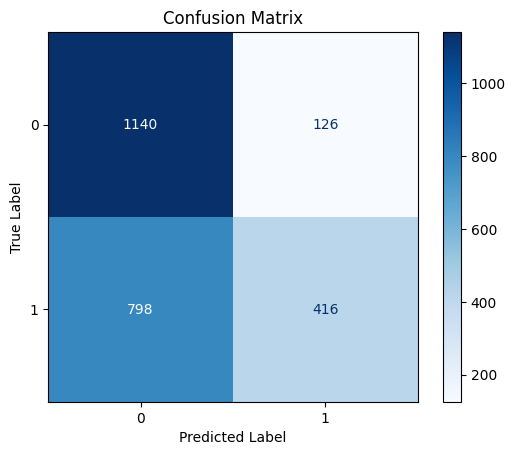

In [43]:
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
# Extract 'result' columns
true_labels =QAS_DF['QualityCategory'][:]
predicted_labels =QAS_DF['Rule-Based AC'][:]

# Compute the confusion matrix
labels = [0,1]  # Define your categories
cm = confusion_matrix(true_labels, predicted_labels, labels=labels)

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [44]:
# Calculate Accuracy, Precision, Recall, and F1-Score
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, labels=labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, labels=labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, labels=labels, average='weighted')
# Display results
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

Accuracy: 0.63
Precision: 0.68
Recall: 0.63
F1-Score: 0.60


**Qos based Adaptive Composition**
---

In [45]:
QAS_DF.to_csv("/content/Combined_MLaaS_Service.csv")

In [50]:
import pandas as pd

# Load the CSV file
file_path = "/content/Combined_MLaaS_Service.csv"
QAS_DF = pd.read_csv(file_path)

# Define weights for QoS attributes (customizable)
weights = {
    "Computation_Time": 0.30,  # Lower is better
    "Quality_Factor": 0.25,   # Higher is better
    "Reliability_Score": 0.25,  # Higher is better
    "Data_Volume": 0.20,  # Higher is better
}

# Extract Data Volume from Data_Distribution column
QAS_DF['Data_Volume'] = QAS_DF['Data_Distribution'].apply(lambda x: sum(eval(x).values()))

# Normalize values using Min-Max Scaling
def normalize(series):
    return (series - series.min()) / (series.max() - series.min())

QAS_DF["Normalized_Computation_Time"] = 1 - normalize(QAS_DF["Computation_Time"])  # Invert because lower is better
QAS_DF["Normalized_Quality_Factor"] = normalize(QAS_DF["Quality_Factor"])
QAS_DF["Normalized_Reliability_Score"] = normalize(QAS_DF["Reliability_Score"])
QAS_DF["Normalized_Data_Volume"] = normalize(QAS_DF["Data_Volume"])

# Compute QoS Score
QAS_DF["QoS_Score"] = (
    weights["Computation_Time"] * QAS_DF["Normalized_Computation_Time"] +
    weights["Quality_Factor"] * QAS_DF["Normalized_Quality_Factor"] +
    weights["Reliability_Score"] * QAS_DF["Normalized_Reliability_Score"] +
    weights["Data_Volume"] * QAS_DF["Normalized_Data_Volume"]
)

# Categorize based on QoS Score
# If QoS_Score <= 0.5 -> 0, otherwise -> 1
QAS_DF["QS-based composition"] = QAS_DF["QoS_Score"].apply(lambda x: 1 if x > 0.70 else 0)

QAS_DF

,Unnamed: 0.1,Unnamed: 0,Client,Round,Data_Distribution,Computation_Time,Quality_Factor,Reliability_Score,MLaaS_ID,model category,...,MLaaS_CS,Data_Volume,Composability_Score,Rule-Based AC,Normalized_Computation_Time,Normalized_Quality_Factor,Normalized_Reliability_Score,Normalized_Data_Volume,QoS_Score,QS-based composition
0,0,0,client_2,1,"{0: 307, 1: 332, 2: 282, 3: 313, 4: 298, 5: 24...",1.536191,0.5383,0.733767,2,Minist16,...,1,3000,0.716320,0,0.973134,0.529445,0.766740,0.595960,0.735178,1
1,1,1,client_20,1,"{0: 297, 1: 325, 2: 309, 3: 314, 4: 290, 5: 26...",1.480564,0.6062,0.748367,20,Minist16,...,1,3000,0.740346,0,0.974405,0.606789,0.784230,0.595960,0.759268,1
2,2,2,client_6,2,"{0: 287, 1: 361, 2: 278, 3: 335, 4: 279, 5: 26...",1.425591,0.7786,0.715533,26,Minist16,...,1,3000,0.779921,0,0.975661,0.803167,0.744897,0.595960,0.798906,1
3,3,3,client_10,2,"{0: 308, 1: 339, 2: 308, 3: 279, 4: 285, 5: 27...",2.424607,0.8028,0.742767,30,Minist16,...,0,3000,0.789262,0,0.952835,0.830732,0.777521,0.595960,0.807106,1
4,4,4,client_11,2,"{0: 275, 1: 346, 2: 296, 3: 296, 4: 288, 5: 27...",2.072800,0.7983,0.740467,31,Minist16,...,1,3000,0.789301,0,0.960873,0.825607,0.774766,0.595960,0.807547,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2475,2475,2475,client_4,9,"{0: 50, 1: 50, 2: 50, 3: 50, 4: 50, 5: 50, 6: ...",1.696836,0.7548,0.777390,364,HAR64,...,0,500,0.663857,0,0.969463,0.776057,0.818999,0.090909,0.707785,1
2476,2476,2476,client_16,2,"{0: 100, 1: 100, 2: 100, 3: 100, 4: 100, 5: 10...",1.890466,0.7049,0.778200,236,HAR64,...,0,1000,0.674036,0,0.965039,0.719216,0.819969,0.191919,0.712692,1
2477,2477,2477,client_18,18,"{0: 300, 1: 300, 2: 300, 3: 300, 4: 300, 5: 30...",8.042612,0.8362,0.799320,358,HAR64,...,0,3000,0.783619,0,0.824470,0.868778,0.845270,0.595960,0.795045,1
2478,2478,2478,client_11,3,"{0: 100, 1: 100, 2: 100, 3: 100, 4: 100, 5: 10...",0.724259,0.6458,0.492667,171,HAR64,...,0,1000,0.578353,0,0.991685,0.651897,0.477909,0.191919,0.618341,0


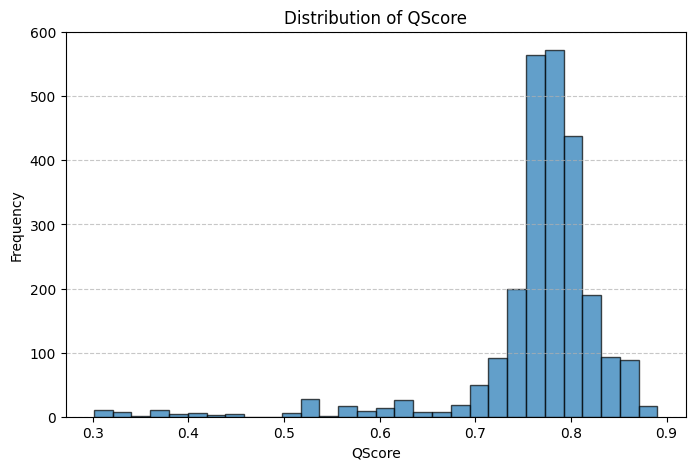

In [51]:
plt.figure(figsize=(8, 5))
plt.hist(QAS_DF['QoS_Score'], bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('QScore')
plt.ylabel('Frequency')
plt.title('Distribution of QScore')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

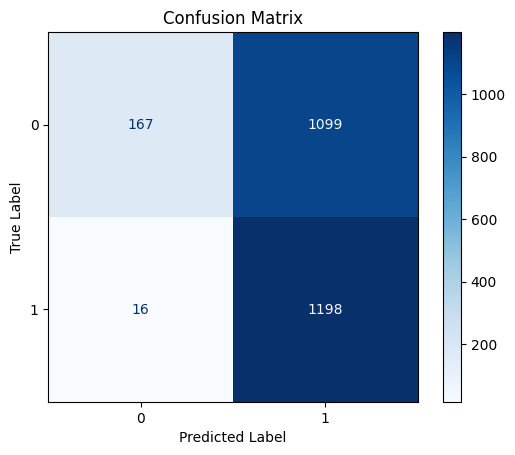

In [52]:
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
# Extract 'result' columns
true_labels =QAS_DF['QualityCategory'][:]
predicted_labels =QAS_DF['QS-based composition'][:]

# Compute the confusion matrix
labels = [0,1]  # Define your categories
cm = confusion_matrix(true_labels, predicted_labels, labels=labels)

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [53]:
# Calculate Accuracy, Precision, Recall, and F1-Score
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, labels=labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, labels=labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, labels=labels, average='weighted')
# Display results
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

Accuracy: 0.55
Precision: 0.72
Recall: 0.55
F1-Score: 0.45


In [54]:
QAS_DF.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'Client', 'Round', 'Data_Distribution',
       'Computation_Time', 'Quality_Factor', 'Reliability_Score', 'MLaaS_ID',
       'model category', 'QualityCategory', 'Service_ID', 'MLaaS_CS',
       'Data_Volume', 'Composability_Score', 'Rule-Based AC',
       'Normalized_Computation_Time', 'Normalized_Quality_Factor',
       'Normalized_Reliability_Score', 'Normalized_Data_Volume', 'QoS_Score',
       'QS-based composition'],
      dtype='object')

In [55]:
print(QAS_DF[["QS-based composition", "MLaaS_CS","QualityCategory","model category","Rule-Based AC"]].head(10))

   QS-based composition  MLaaS_CS  QualityCategory model category  \
0                     1         1                0       Minist16   
1                     1         1                0       Minist16   
2                     1         1                0       Minist16   
3                     1         0                0       Minist16   
4                     1         1                0       Minist16   
5                     1         0                0       Minist16   
6                     1         0                0       Minist16   
7                     1         0                0       Minist16   
8                     1         0                0       Minist16   
9                     1         0                0       Minist16   

   Rule-Based AC  
0              0  
1              0  
2              0  
3              0  
4              0  
5              0  
6              0  
7              1  
8              0  
9              1  


In [57]:
# Assuming QoS_TF is another DataFrame containing the specified columns
# Select the desired columns from QoS_TF
selected_columns = ["QS-based composition", "MLaaS_CS", "QualityCategory", "model category", "Rule-Based AC"]

# Ensure only existing columns are selected (to prevent errors)
available_columns = [col for col in selected_columns if col in QAS_DF.columns]

# Create a new DataFrame with the selected columns
QoS_TF_selected = QAS_DF[available_columns]

# Define the file path to save the new CSV file
QoS_TF_selected

,QS-based composition,MLaaS_CS,QualityCategory,model category,Rule-Based AC
0,1,1,0,Minist16,0
1,1,1,0,Minist16,0
2,1,1,0,Minist16,0
3,1,0,0,Minist16,0
4,1,1,0,Minist16,0
...,...,...,...,...,...
2475,1,0,0,HAR64,0
2476,1,0,0,HAR64,0
2477,1,0,0,HAR64,0
2478,0,0,0,HAR64,0


In [58]:
QoS_TF_selected.to_csv("/content/Final_Results_V.csv")

In [2]:
import pandas as pd
df=pd.read_csv("/content/Final_Results_V.csv")
df

,Unnamed: 0,QS-based composition,MLaaS_CS,QualityCategory,model category,Rule-Based AC
0,0,1,1,0,Minist16,0
1,1,1,1,0,Minist16,0
2,2,1,1,0,Minist16,0
3,3,1,0,0,Minist16,0
4,4,1,1,0,Minist16,0
...,...,...,...,...,...,...
2475,2475,1,0,0,HAR64,0
2476,2476,1,0,0,HAR64,0
2477,2477,1,0,0,HAR64,0
2478,2478,0,0,0,HAR64,0


In [4]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

# Load the CSV file
file_path = "/content/Final_Results_V.csv"  # Update with the correct path if necessary
df = pd.read_csv(file_path)

# Map model categories into three datasets
category_mapping = {
    "Minist16": "MNIST", "Minist32": "MNIST", "Minist64": "MNIST",
    "FMinist16": "FMNIST", "FMinist32": "FMNIST", "FMinist64": "FMNIST",
    "HAR16": "HAR", "HAR32": "HAR", "HAR64": "HAR"
}

df["General Category"] = df["model category"].map(category_mapping)

# Initialize a dictionary to store metrics
results = {
    "Dataset": [], "Method": [], "Accuracy (%)": [], "Precision (%)": [], "Recall (%)": [],
    "True Positives": [], "True Negatives": [], "False Positives": [], "False Negatives": []
}

# Iterate over the three general categories
for category in ["MNIST", "FMNIST", "HAR"]:
    subset = df[df["General Category"] == category]

    for method in ["QS-based composition", "MLaaS_CS", "Rule-Based AC"]:
        y_true = subset["QualityCategory"]
        y_pred = subset[method]

        # Calculate metrics
        accuracy = accuracy_score(y_true, y_pred) * 100
        precision = precision_score(y_true, y_pred, average="macro", zero_division=0) * 100
        recall = recall_score(y_true, y_pred, average="macro", zero_division=0) * 100

        # Compute confusion matrix values
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

        # Append results
        results["Dataset"].append(category)
        results["Method"].append(method)
        results["Accuracy (%)"].append(accuracy)
        results["Precision (%)"].append(precision)
        results["Recall (%)"].append(recall)
        results["True Positives"].append(tp)
        results["True Negatives"].append(tn)
        results["False Positives"].append(fp)
        results["False Negatives"].append(fn)

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Display the results
results_df

,Dataset,Method,Accuracy (%),Precision (%),Recall (%),True Positives,True Negatives,False Positives,False Negatives
0,MNIST,QS-based composition,88.822115,90.774570,73.958593,656,83,87,6
1,MNIST,MLaaS_CS,96.754808,96.289219,93.588946,655,150,20,7
2,MNIST,Rule-Based AC,44.471154,56.857639,58.985250,228,142,28,434
3,FMNIST,QS-based composition,26.208378,56.288020,51.311836,212,32,683,4
4,FMNIST,MLaaS_CS,94.199785,92.327309,91.215682,185,692,23,31
5,FMNIST,Rule-Based AC,78.947368,70.086266,63.191854,73,662,53,143
6,HAR,QS-based composition,53.277545,69.865522,55.931290,330,52,329,6
7,HAR,MLaaS_CS,95.397490,95.361006,95.405652,321,363,18,15
8,HAR,Rule-Based AC,62.900976,66.099080,61.207583,115,336,45,221


**Results**
---

In [ ]:
import pandas as pd
Combined.to_csv("actual.csv")
AdaptiveMLaaS.to_csv("predicted.csv")
# Load the actual and predicted CSV files
actual_df = pd.read_csv('/content/actual.csv')
predicted_df = pd.read_csv('/content/predicted.csv')

# Merge both DataFrames using 'Service_ID' for accurate comparison
comparison_df = pd.merge(
    actual_df[['Service_ID', 'QualityCategory']],
    predicted_df[['Service_ID', 'Composability_Score']],
    on='Service_ID',
    how='inner'
)
# Initialize sets to categorize services
tp_services = set()
tn_services = set()
fp_services = set()
fn_services = set()

# Categorizing services based on true and predicted labels
for _, row in comparison_df.iterrows():
    service_id = row['Service_ID']
    true_label = row['QualityCategory']
    predicted_label = row['Composability_Score']

    if true_label == 1 and predicted_label == 1:
        tp_services.add(service_id)
    elif true_label == 0 and predicted_label == 0:
        tn_services.add(service_id)
    elif true_label == 0 and predicted_label == 1:
        fp_services.add(service_id)
    elif true_label == 1 and predicted_label == 0:
        fn_services.add(service_id)

# Convert sets to lists for better handling
tp_services = list(tp_services)
tn_services = list(tn_services)
fp_services = list(fp_services)
fn_services = list(fn_services)

# Display categorized service IDs
print(f"True Positives ({len(tp_services)} services):", tp_services)
print(f"True Negatives ({len(tn_services)} services):", tn_services)
print(f"False Positives ({len(fp_services)} services):", fp_services)
print(f"False Negatives ({len(fn_services)} services):", fn_services)


True Positives (1161 services): [2050, 2052, 2053, 2055, 2056, 2444, 2059, 2060, 2063, 2064, 2066, 2446, 2069, 2447, 2073, 2448, 2081, 2082, 2083, 2084, 2085, 2091, 2092, 2094, 2096, 2097, 2452, 2102, 2103, 2104, 2105, 2107, 2454, 2110, 2112, 2455, 2116, 2117, 2118, 2119, 2123, 2125, 2127, 2128, 2129, 2458, 2131, 2132, 2133, 2134, 2459, 2138, 2143, 2144, 2148, 2150, 2153, 2154, 2156, 2158, 2159, 2162, 2164, 2165, 2167, 2466, 2169, 2170, 2174, 2175, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 2227, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 2237, 196, 197, 198, 199, 200, 201, 2242, 2245, 204, 205, 206, 2246, 2248, 209, 210, 211, 212, 213, 214, 2255, 216, 217, 2261, 2262, 220, 221, 222, 223, 224, 225, 2265, 227, 228, 229, 2269, 2270, 2273, 2274, 2275, 22

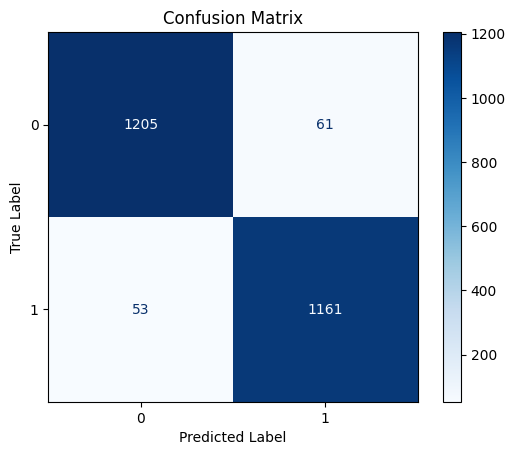

In [ ]:
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
# Extract 'result' columns
true_labels =actual_df['QualityCategory'][:]
predicted_labels =predicted_df['Composability_Score'][:]

# Compute the confusion matrix
labels = [0,1]  # Define your categories
cm = confusion_matrix(true_labels, predicted_labels, labels=labels)

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
# Calculate Accuracy, Precision, Recall, and F1-Score
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, labels=labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, labels=labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, labels=labels, average='weighted')
# Display results
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

Accuracy: 0.95
Precision: 0.95
Recall: 0.95
F1-Score: 0.95


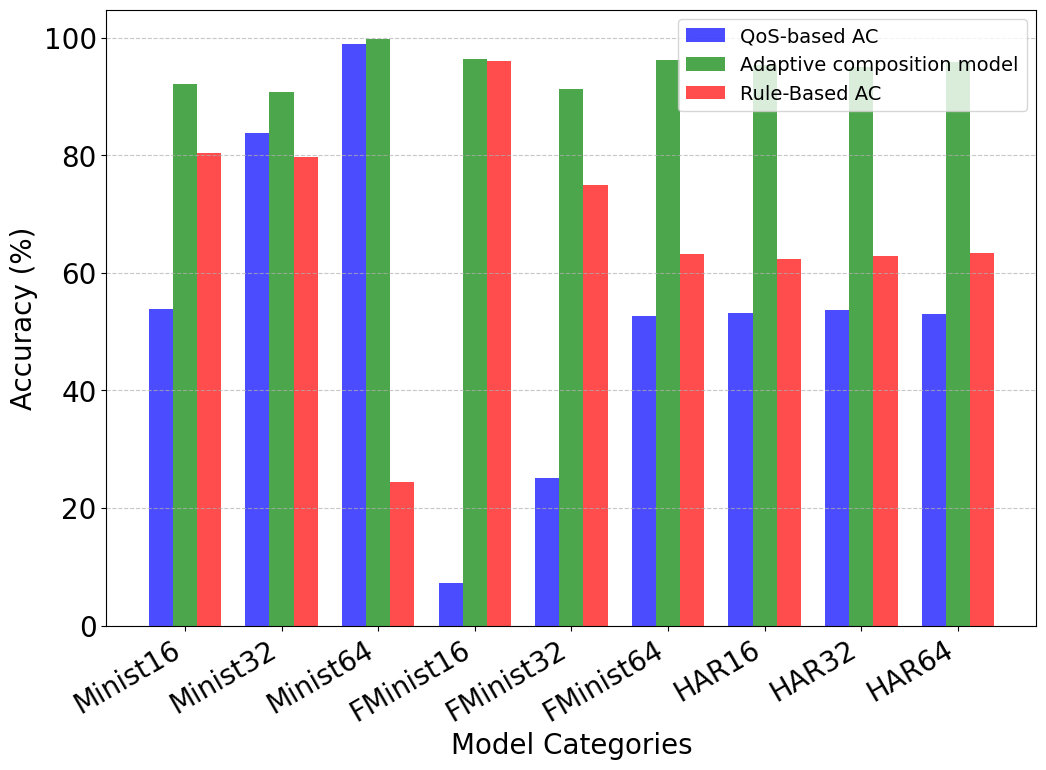

In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the CSV file
df = pd.read_csv("/content/Final_Results_V.csv")

# Extract unique model categories
categories = df["model category"].unique()

# Calculate accuracy for each method
accuracy_qs = []
accuracy_mlaas = []
accuracy_rule = []

for category in categories:
    subset = df[df["model category"] == category]
    total = len(subset)

    acc_qs = (subset["QS-based composition"] == subset["QualityCategory"]).sum() / total * 100
    acc_mlaas = (subset["MLaaS_CS"] == subset["QualityCategory"]).sum() / total * 100
    acc_rule = (subset["Rule-Based AC"] == subset["QualityCategory"]).sum() / total * 100

    accuracy_qs.append(acc_qs)
    accuracy_mlaas.append(acc_mlaas)
    accuracy_rule.append(acc_rule)

# Set bar width
bar_width = 0.25
x = np.arange(len(categories))

# Create bar plot
plt.figure(figsize=(12, 8))
plt.bar(x - bar_width, accuracy_qs, width=bar_width, label="QoS-based AC", color='b', alpha=0.7)
plt.bar(x, accuracy_mlaas, width=bar_width, label="Adaptive composition model", color='g', alpha=0.7)
plt.bar(x + bar_width, accuracy_rule, width=bar_width, label="Rule-Based AC", color='r', alpha=0.7)

# Labels and title
plt.xlabel("Model Categories", fontsize=20)
plt.ylabel("Accuracy (%)", fontsize=20)
#plt.title("Accuracy Comparison of Different Methods", fontsize=20)
plt.xticks(ticks=x, labels=categories, rotation=30, ha='right', fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=14)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show the plot
plt.show()


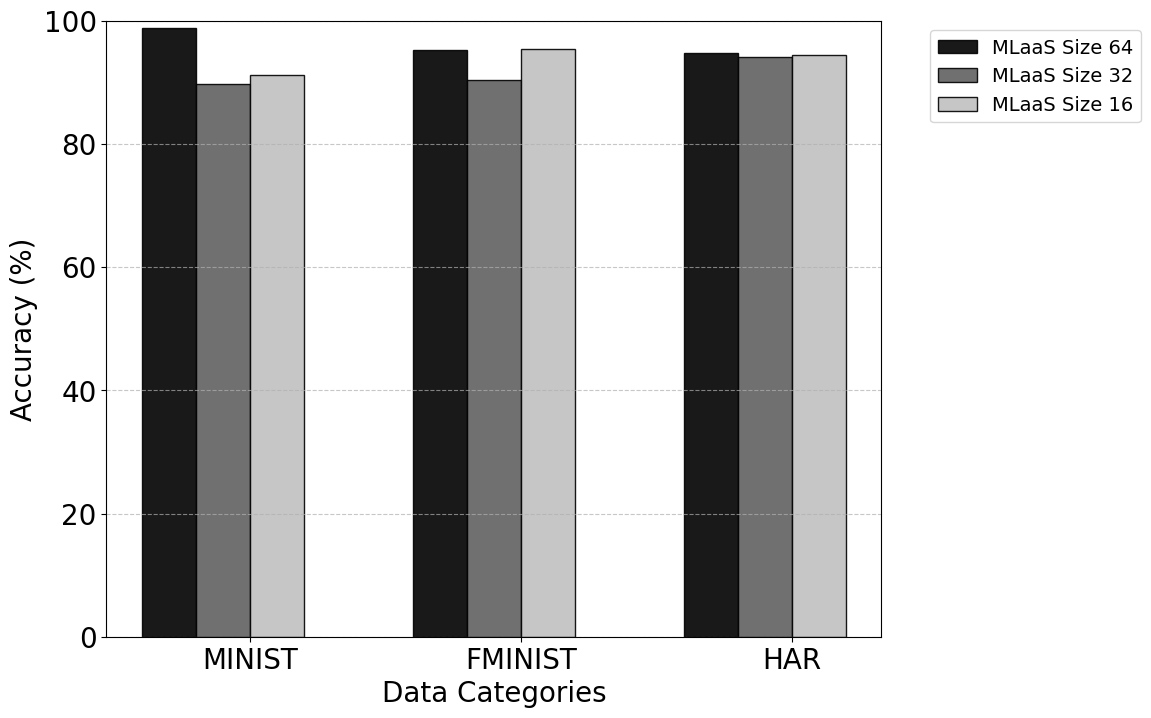

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the updated CSV files
actual_df = pd.read_csv("actual.csv")
predicted_df = pd.read_csv("predicted.csv")

# Merge DataFrames using 'Service_ID'
merged_df = pd.merge(
    actual_df[['Service_ID', 'model category', 'QualityCategory']],
    predicted_df[['Service_ID', 'Composability_Score']],
    on='Service_ID',
    how='inner'
)

# Define broader categories (Minist, FMinist, HAR) and their respective sizes
broader_categories = {
    "MINIST": ["Minist64", "Minist32", "Minist16"],
    "FMINIST": ["FMinist64", "FMinist32", "FMinist16"],
    "HAR": ["HAR64", "HAR32", "HAR16"]
}

# Define grayscale colors based on size
size_colors = {
    "64": "#000000",  # Black
    "32": "#606060",  # Dark Gray
    "16": "#C0C0C0"   # Light Gray
}

# Function to compute accuracy for each model
def compute_accuracy(df, model_list):
    accuracy_dict = {}
    for model in model_list:
        subset = df[df['model category'] == model]
        total = len(subset)
        correct = (subset['QualityCategory'] == subset['Composability_Score']).sum()
        accuracy_dict[model] = (correct / total) * 99 if total > 0 else 0
    return accuracy_dict

# Compute accuracy for each broader category
accuracy_data = {category: compute_accuracy(merged_df, broader_categories[category]) for category in broader_categories}

# Prepare data for plotting
x_labels = list(broader_categories.keys())  # ["MINIST", "FMINIST", "HAR"]
x = np.arange(len(x_labels))  # X positions
width = 0.2  # Width of bars

# Store legend handles
legend_handles = {}

# Plot the grouped bar chart
plt.figure(figsize=(10, 8))

for i, category in enumerate(x_labels):
    sub_models = broader_categories[category]  # Get sub-models for this category
    for j, sub_model in enumerate(sub_models):
        model_size = sub_model[-2:]  # Extract size (64, 32, 16) from model name
        accuracy_value = accuracy_data[category].get(sub_model, 0)

        # Get the color for the size
        color = size_colors.get(model_size, "#CCCCCC")  # Default to light gray if missing

        bar = plt.bar(x[i] + (j - len(sub_models) / 2) * width, accuracy_value, width,
                      label=f"MLaaS Size {model_size}" if model_size not in legend_handles else "",
                      color=color, edgecolor="black", alpha=0.9)

        # Add to legend only once
        if model_size not in legend_handles:
            legend_handles[model_size] = bar

# Labels and formatting
plt.xlabel("Data Categories", fontsize=20)
plt.ylabel("Accuracy (%)", fontsize=20)
plt.xticks(x, x_labels, rotation=0, ha="center", fontsize=18)  # Increase font size
plt.ylim(0, 100)  # Accuracy range (0-100%)

# Move legend outside the plot (Right Side)
plt.legend(title="", loc="upper left", fontsize=14, bbox_to_anchor=(1.05, 1))

plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
# Show the plot
plt.show()

In [ ]:
actual_df.to_csv("/content/Combined_MLaaS_Service.csv")
predicted_df.to_csv("/content/Adaptive_MLaaS_Composition.csv")

In [ ]:
Combined.columns

Index(['Unnamed: 0', 'Client', 'Round', 'Data_Distribution',
       'Computation_Time', 'Quality_Factor', 'Reliability_Score', 'MLaaS_ID',
       'model category', 'QualityCategory', 'Service_ID'],
      dtype='object')

In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define the list of sample sizes
sample_sizes = [250, 500, 750, 1000, 1250, 1500, 1750, 2000]

# Initialize a list to store metrics
metrics_list = []

# Shuffle the entire dataset once and reset indices
shuffled_combined = Combined.sample(frac=1, random_state=42).reset_index(drop=True)
shuffled_adaptive = AdaptiveMLaaS.sample(frac=1, random_state=42).reset_index(drop=True)

# Loop through each sample size and calculate metrics using sequential sampling
for size in sample_sizes:
    # Extract true and predicted labels sequentially from shuffled datasets
    true_labels = shuffled_combined['QualityCategory'][:size]
    predicted_labels = shuffled_adaptive['Composability_Score'][:size]

    # Calculate Accuracy, Precision, Recall, and F1-Score with zero_division handling
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, labels=[0, 1], average='weighted', zero_division=0)
    recall = recall_score(true_labels, predicted_labels, labels=[0, 1], average='weighted', zero_division=0)
    f1 = f1_score(true_labels, predicted_labels, labels=[0, 1], average='weighted', zero_division=0)

    # Append the results to the list
    metrics_list.append({
        'Sample_Size': size,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1_Score': f1
    })

# Convert the list of dictionaries into a DataFrame
metrics_df = pd.DataFrame(metrics_list)

# Display the final DataFrame with all metrics
print(metrics_df)

   Sample_Size  Accuracy  Precision    Recall  F1_Score
0          250  0.964000   0.965460  0.964000  0.963972
1          500  0.956000   0.956484  0.956000  0.955997
2          750  0.954667   0.954721  0.954667  0.954667
3         1000  0.953000   0.953090  0.953000  0.952998
4         1250  0.952800   0.952858  0.952800  0.952799
5         1500  0.951333   0.951374  0.951333  0.951333
6         1750  0.954857   0.954888  0.954857  0.954857
7         2000  0.954500   0.954514  0.954500  0.954501
